In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import random
from dateutil.parser import parse

In [6]:
df = pd.read_csv('extended_nypd_crime_data.csv')

In [7]:
#create a new dataframe with only the columns 'CMPLNT_FR_DT', 'CMPLNT_FR_TM' and 'OFNS_DESC'
filtered_df = df[['cmplnt_fr_dt', 'cmplnt_fr_tm', 'ofns_desc']]


#remove the last 13 characters from the 'cmplnt_fr_tm' column
filtered_df['cmplnt_fr_dt'] = filtered_df['cmplnt_fr_dt'].str[:-13]

#drop all values that include "null" in the 'cmplnt_fr_tm' column
filtered_df = filtered_df[~filtered_df['cmplnt_fr_tm'].str.contains("null")]

#Combine the date and time columns into a single column
filtered_df['datetime'] = filtered_df['cmplnt_fr_dt'] + ' ' + filtered_df['cmplnt_fr_tm']

#Convert the 'datetime' column to datetime format
filtered_df['datetime'] = pd.to_datetime(filtered_df['datetime'])

/var/folders/s5/83_c6qwd24vgpy6ybcz6q4ww0000gn/T/ipykernel_21307/726440253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cmplnt_fr_dt'] = filtered_df['cmplnt_fr_dt'].str[:-13]


,cmplnt_fr_dt,cmplnt_fr_tm,ofns_desc,datetime
0,2010-01-01,01:30:00,PETIT LARCENY,2010-01-01 01:30:00
1,2010-01-01,12:00:00,PETIT LARCENY,2010-01-01 12:00:00
2,2010-01-01,20:00:00,PETIT LARCENY,2010-01-01 20:00:00
3,2010-01-01,10:00:00,PETIT LARCENY,2010-01-01 10:00:00
4,2010-01-01,00:00:00,PETIT LARCENY,2010-01-01 00:00:00
5,2010-01-01,00:00:00,PETIT LARCENY,2010-01-01 00:00:00
6,2010-01-01,01:30:00,PETIT LARCENY,2010-01-01 01:30:00
7,2010-01-01,12:00:00,PETIT LARCENY,2010-01-01 12:00:00
8,2010-01-01,11:00:00,PETIT LARCENY,2010-01-01 11:00:00
9,2010-01-01,18:16:00,PETIT LARCENY,2010-01-01 18:16:00


In [8]:
#rename the columns to work with Prophet
filtered_df = filtered_df.rename(columns={'datetime': 'ds', 'ofns_desc': 'y'})

,cmplnt_fr_dt,cmplnt_fr_tm,y,ds
0,2010-01-01,01:30:00,PETIT LARCENY,2010-01-01 01:30:00
1,2010-01-01,12:00:00,PETIT LARCENY,2010-01-01 12:00:00
2,2010-01-01,20:00:00,PETIT LARCENY,2010-01-01 20:00:00
3,2010-01-01,10:00:00,PETIT LARCENY,2010-01-01 10:00:00
4,2010-01-01,00:00:00,PETIT LARCENY,2010-01-01 00:00:00
5,2010-01-01,00:00:00,PETIT LARCENY,2010-01-01 00:00:00
6,2010-01-01,01:30:00,PETIT LARCENY,2010-01-01 01:30:00
7,2010-01-01,12:00:00,PETIT LARCENY,2010-01-01 12:00:00
8,2010-01-01,11:00:00,PETIT LARCENY,2010-01-01 11:00:00
9,2010-01-01,18:16:00,PETIT LARCENY,2010-01-01 18:16:00


In [9]:
#sum all the crimes that happened on the same day
filtered_df = filtered_df.groupby('cmplnt_fr_dt').size().reset_index(name='y')

,cmplnt_fr_dt,y
0,2010-01-01,2496
1,2010-01-02,1180
2,2010-01-03,1047
3,2010-01-04,1218
4,2010-01-05,1353
5,2010-01-06,1430
6,2010-01-07,1538
7,2010-01-08,1496
8,2010-01-09,1300
9,2010-01-10,1220


In [10]:
filtered_df = filtered_df.rename(columns={'cmplnt_fr_dt': 'ds'})

In [11]:
#sort the dataframe based on crimes per day
min_max_df = filtered_df.sort_values(by='y', ascending=True)
display(min_max_df.head(15))
display(min_max_df.tail(15))

,ds,y
3740,2020-03-29,281
4411,2022-01-29,282
3768,2020-04-26,287
4740,2022-12-24,290
3733,2020-03-22,301
4742,2022-12-26,303
4741,2022-12-25,309
4412,2022-01-30,315
4050,2021-02-02,319
3745,2020-04-03,323


,ds,y
273,2010-10-01,1841
1916,2015-04-01,1854
1673,2014-08-01,1856
974,2012-09-01,1860
1946,2015-05-01,1915
882,2012-06-01,1937
516,2011-06-01,1952
2557,2017-01-01,2066
1826,2015-01-01,2080
730,2012-01-01,2181


In [12]:
date_df = min_max_df

#remove the first 5 characters from the 'ds' column
date_df['ds'] = date_df['ds'].str[5:]

#sum all the crimes that happened on the same day
date_df = date_df.groupby('ds').sum().reset_index()
date_df.head(10)

,ds,y
0,01-01,23918
1,01-02,11725
2,01-03,11761
3,01-04,12100
4,01-05,12624
5,01-06,12580
6,01-07,12255
7,01-08,12597
8,01-09,12592
9,01-10,13193


In [13]:
#sort the dataframe based on crimes per day
date_df = date_df.sort_values(by='y', ascending=False).reset_index(drop=True)
display(date_df.head(15))
display(date_df.tail(15))

,ds,y
0,01-01,23918
1,06-01,18563
2,09-01,17372
3,07-01,17271
4,08-01,16768
5,10-01,16700
6,05-01,16370
7,11-01,16276
8,04-01,16121
9,03-01,16111


,ds,y
351,11-24,11859
352,01-24,11810
353,01-03,11761
354,01-02,11725
355,02-13,11723
356,02-09,11718
357,12-28,11525
358,12-30,11494
359,12-29,11158
360,12-31,11100


In [14]:
month_df = min_max_df

#remove the last 3 characters from the 'ds' column
month_df['ds'] = month_df['ds'].str[:-3]

#sum all the crimes that happened on the same month
month_df = month_df.groupby('ds').sum().reset_index()


In [20]:
#sort the dataframe based on crimes per month
month_df = month_df.sort_values(by='ds', ascending=True).reset_index(drop=True)
month_df

,ds,y
0,01,399568
1,02,352800
2,03,402109
3,04,396619
4,05,430571
5,06,424006
6,07,440659
7,08,438859
8,09,422997
9,10,431073


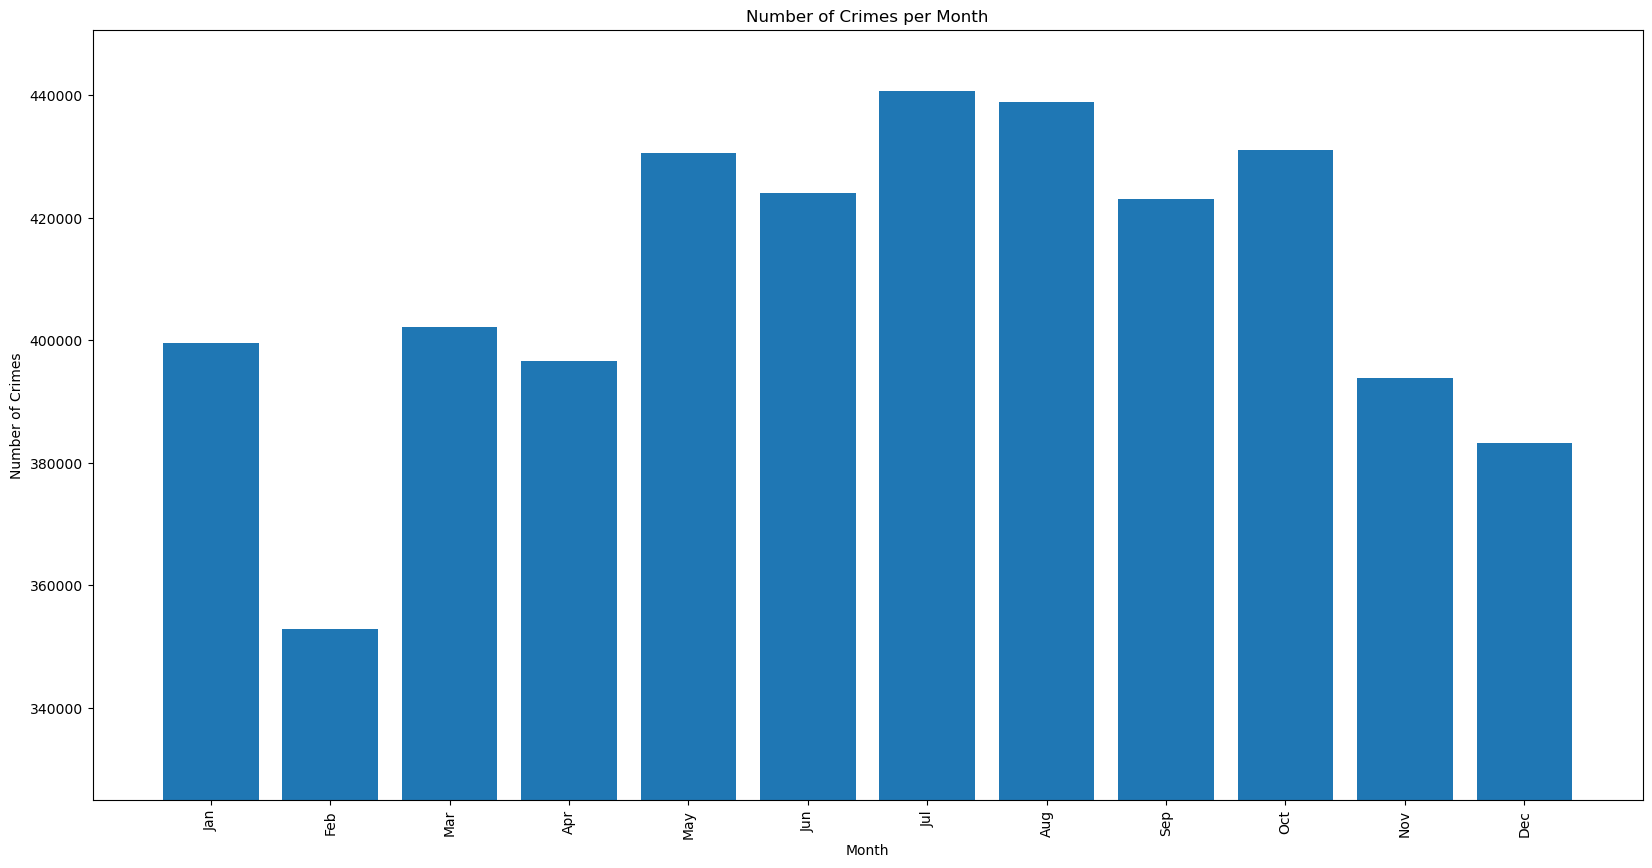

In [24]:
#relable the x-axis with the name of the months
month_df['ds'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#create a bar chart to show the number of crimes per month
plt.figure(figsize=(20, 10))
plt.bar(month_df['ds'], month_df['y'])
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes per Month')
plt.xticks(rotation=90)
plt.ylim(325000, max(month_df['y']) + 10000)  # Set the limits of y-axis
plt.show()

In [36]:
day_of_month_df = filtered_df

#remove the first 8 characters from the 'ds' column
day_of_month_df['ds'] = day_of_month_df['ds'].str[8:]

#sum all the crimes that happened on the same day of the month
day_of_month_df = day_of_month_df.groupby('ds').sum().reset_index()
day_of_month_df.head(10)

,ds,y
0,01,206556
1,02,160646
2,03,159765
3,04,160456
4,05,163318
5,06,159134
6,07,159112
7,08,159342
8,09,159077
9,10,164263


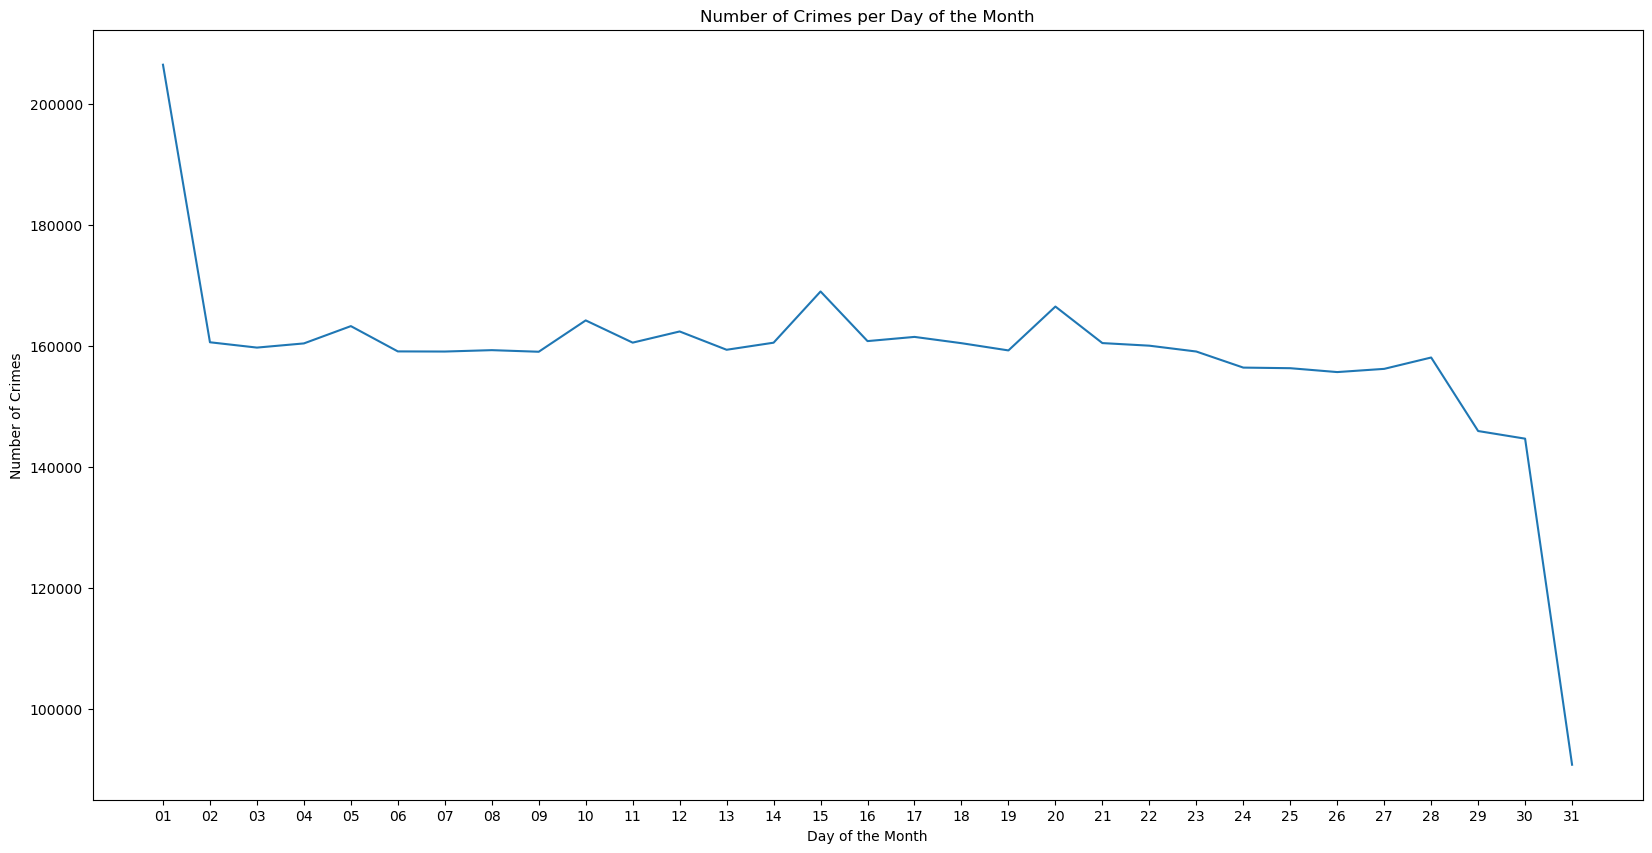

In [37]:
#graph the number of crimes per day of the month
plt.figure(figsize=(20, 10))
plt.plot(day_of_month_df['ds'], day_of_month_df['y'])
plt.xlabel('Day of the Month')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes per Day of the Month')
plt.show()

In [38]:
ordered_day_of_month_df = day_of_month_df
#sort the dataframe based on the amount of crimes per day of the month
ordered_day_of_month_df = ordered_day_of_month_df.sort_values(by='y', ascending=False).reset_index(drop=True)
ordered_day_of_month_df.head(10)

,ds,y
0,01,206556
1,15,169047
2,20,166553
3,10,164263
4,05,163318
5,12,162433
6,17,161533
7,16,160839
8,02,160646
9,11,160585


In [39]:
ordered_day_of_month_df

,ds,y
0,01,206556
1,15,169047
2,20,166553
3,10,164263
4,05,163318
5,12,162433
6,17,161533
7,16,160839
8,02,160646
9,11,160585


22:06:22 - cmdstanpy - INFO - Chain [1] start processing
22:06:22 - cmdstanpy - INFO - Chain [1] done processing


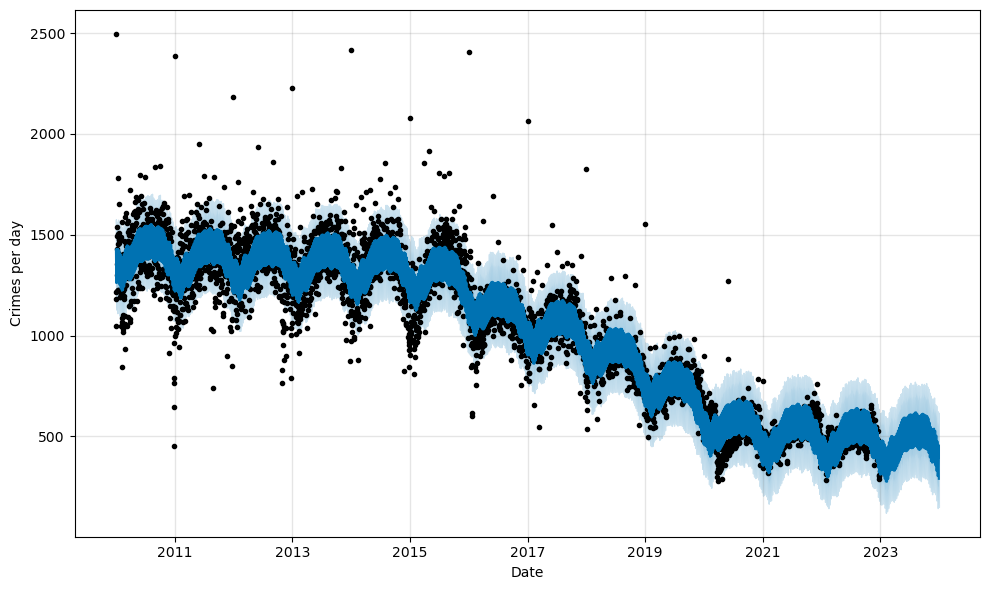

In [25]:
model = Prophet()

model.fit(filtered_df)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

fig1 = model.plot(forecast, xlabel='Date', ylabel='Crimes per day')

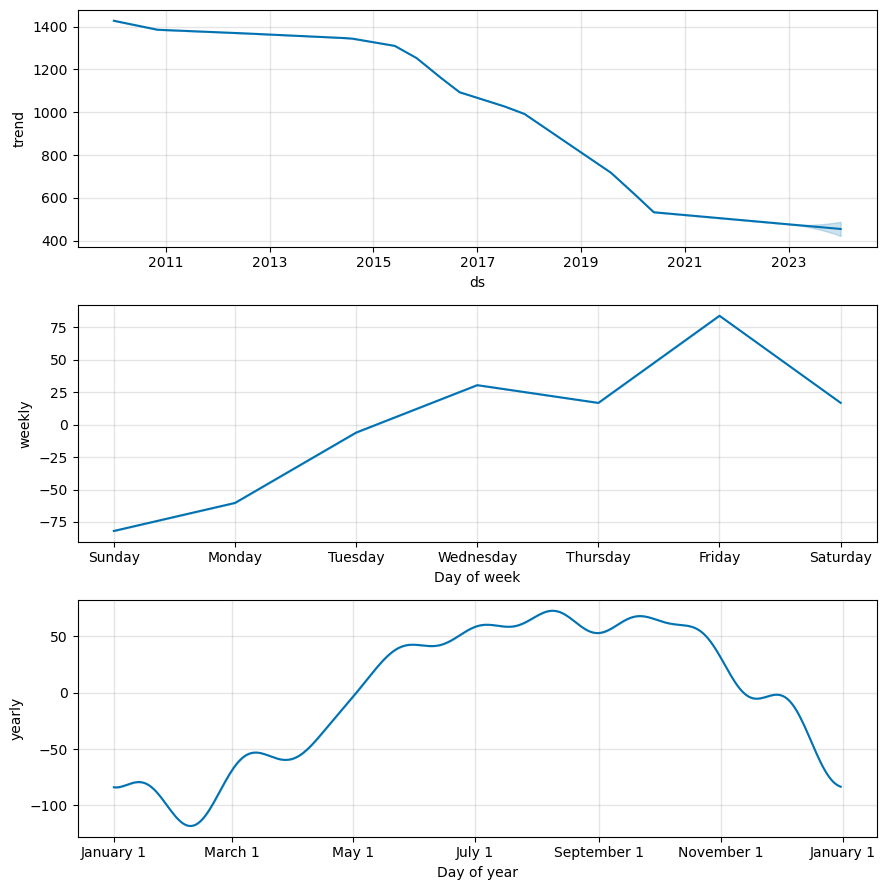

In [26]:
fig2 = model.plot_components(forecast)

In [ ]:
#convert the 'ds' column to a datetime format
filtered_df['ds'] = pd.to_datetime(filtered_df['ds'])

filtered_df['day_of_week'] = filtered_df['ds'].dt.day_name()
filtered_df['day_of_week'] = pd.Categorical(filtered_df['day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)
filtered_df = filtered_df.sort_values('day_of_week')

#sum all the crimes that happened on the same day of the week
filtered_df = filtered_df.groupby('day_of_week').mean().reset_index()

#create a bar chart of average crime based on the day of the week
plt.bar(filtered_df['day_of_week'], filtered_df['y'])
plt.xlabel('Day of the Week')
plt.ylabel('Average Crime')
plt.title('Average Crime Based on the Day of the Week')
plt.show()

In [ ]:
filtered_df

In [48]:
seasonal_df = df
seasonal_df.head()

,cmplnt_fr_dt,cmplnt_fr_tm,ofns_desc,boro_nm,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex
0,2010-01-01T00:00:00.000,01:30:00,PETIT LARCENY,STATEN ISLAND,(null),UNKNOWN,U,45-64,WHITE,M
1,2010-01-01T00:00:00.000,12:00:00,PETIT LARCENY,STATEN ISLAND,(null),UNKNOWN,U,45-64,WHITE,F
2,2010-01-01T00:00:00.000,20:00:00,PETIT LARCENY,STATEN ISLAND,(null),(null),(null),(null),UNKNOWN,D
3,2010-01-01T00:00:00.000,10:00:00,PETIT LARCENY,STATEN ISLAND,18-24,WHITE,M,45-64,WHITE,F
4,2010-01-01T00:00:00.000,00:00:00,PETIT LARCENY,STATEN ISLAND,(null),UNKNOWN,U,25-44,WHITE,M


In [49]:
#remove all columns except 'cmplnt_fr_dt' and 'ofns_desc'
seasonal_df = seasonal_df[['cmplnt_fr_dt', 'ofns_desc']]

#remove the last 13 characters from the 'cmplnt_fr_dt' column
seasonal_df['cmplnt_fr_dt'] = seasonal_df['cmplnt_fr_dt'].str[:-13]

seasonal_df.head()

/var/folders/s5/83_c6qwd24vgpy6ybcz6q4ww0000gn/T/ipykernel_21307/3032611852.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_df['cmplnt_fr_dt'] = seasonal_df['cmplnt_fr_dt'].str[:-13]


,cmplnt_fr_dt,ofns_desc
0,2010-01-01,PETIT LARCENY
1,2010-01-01,PETIT LARCENY
2,2010-01-01,PETIT LARCENY
3,2010-01-01,PETIT LARCENY
4,2010-01-01,PETIT LARCENY


In [50]:
#combine all the crimes that happened on the same day
seasonal_df = seasonal_df.groupby('cmplnt_fr_dt').size().reset_index(name='y')
seasonal_df.head()

,cmplnt_fr_dt,y
0,2010-01-01,2496
1,2010-01-02,1180
2,2010-01-03,1047
3,2010-01-04,1218
4,2010-01-05,1353


In [58]:
#rename cmplnt_fr_dt to ds and convert it to datetime format
seasonal_df = seasonal_df.rename(columns={'cmplnt_fr_dt': 'ds'})

#drop the last 3 characters from the 'ds' column
seasonal_df['ds'] = seasonal_df['ds'].str[:-3]

#combine all the crimes that happened on the same month
seasonal_df = seasonal_df.groupby('ds').sum().reset_index()


,ds,y,year,month
0,2010-01,43070,62310,JanJanJanJanJanJanJanJanJanJanJanJanJanJanJanJ...
1,2010-02,34192,56280,FebFebFebFebFebFebFebFebFebFebFebFebFebFebFebF...
2,2010-03,42558,62310,MarMarMarMarMarMarMarMarMarMarMarMarMarMarMarM...
3,2010-04,42917,60300,AprAprAprAprAprAprAprAprAprAprAprAprAprAprAprA...
4,2010-05,44924,62310,MayMayMayMayMayMayMayMayMayMayMayMayMayMayMayM...
5,2010-06,44553,60300,JunJunJunJunJunJunJunJunJunJunJunJunJunJunJunJ...
6,2010-07,45195,62310,JulJulJulJulJulJulJulJulJulJulJulJulJulJulJulJ...
7,2010-08,44319,62310,AugAugAugAugAugAugAugAugAugAugAugAugAugAugAugA...
8,2010-09,44440,60300,SepSepSepSepSepSepSepSepSepSepSepSepSepSepSepS...
9,2010-10,45853,62310,OctOctOctOctOctOctOctOctOctOctOctOctOctOctOctO...


In [59]:
#drop all columns except ds and y
seasonal_df = seasonal_df[['ds', 'y']]

In [60]:
seasonal_df['year'] = [parse(d).year for d in seasonal_df.ds]
seasonal_df['month'] = [parse(d).strftime('%b') for d in seasonal_df.ds]
years = seasonal_df['year'].unique()

In [61]:
seasonal_df.head()

,ds,y,year,month
0,2010-01,43070,2010,Jan
1,2010-02,34192,2010,Feb
2,2010-03,42558,2010,Mar
3,2010-04,42917,2010,Apr
4,2010-05,44924,2010,May


/var/folders/s5/83_c6qwd24vgpy6ybcz6q4ww0000gn/T/ipykernel_21307/2460766294.py:8: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot('month', 'y', data=df_year, color=mycolors[i], label=y)


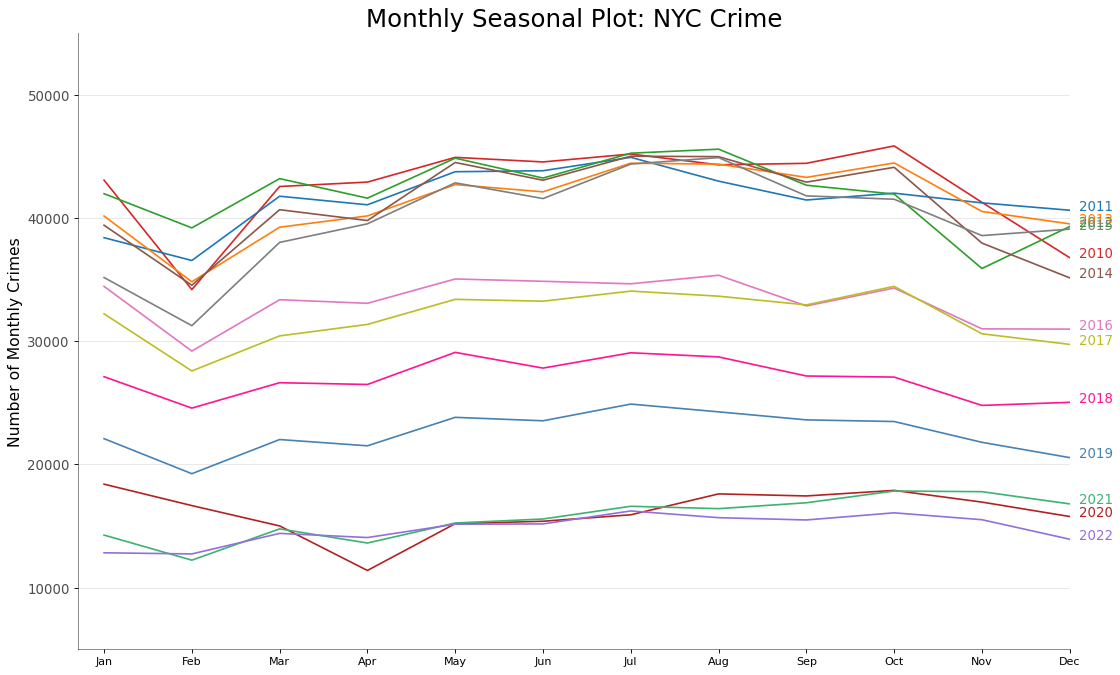

In [70]:
# Draw Plot
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive', 'deeppink', 'steelblue', 'firebrick', 'mediumseagreen', 'mediumpurple']      
plt.figure(figsize=(16,10), dpi= 80)

for i, y in enumerate(years):
    df_year = seasonal_df.loc[seasonal_df.year==y, :]
    if df_year.shape[0] > 0:
        plt.plot('month', 'y', data=df_year, color=mycolors[i], label=y)
        plt.text(df_year.shape[0]-.9, df_year['y'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.ylim(5000,55000)
plt.xlim(-0.3, 11)
plt.ylabel('Number of Monthly Crimes', fontsize=14)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Monthly Seasonal Plot: NYC Crime", fontsize=22)
plt.grid(axis='y', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5)   
#plt.legend(loc='upper right', ncol=2, fontsize=12)
plt.show()

In [71]:
day_of_week_df = df
#remove all columns except 'cmplnt_fr_dt' and 'ofns_desc'
day_of_week_df = day_of_week_df[['cmplnt_fr_dt', 'ofns_desc']]

#remove the last 13 characters from the 'cmplnt_fr_dt' column
day_of_week_df['cmplnt_fr_dt'] = day_of_week_df['cmplnt_fr_dt'].str[:-13]


/var/folders/s5/83_c6qwd24vgpy6ybcz6q4ww0000gn/T/ipykernel_21307/4169807633.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_of_week_df['cmplnt_fr_dt'] = day_of_week_df['cmplnt_fr_dt'].str[:-13]


,cmplnt_fr_dt,ofns_desc
0,2010-01-01,PETIT LARCENY
1,2010-01-01,PETIT LARCENY
2,2010-01-01,PETIT LARCENY
3,2010-01-01,PETIT LARCENY
4,2010-01-01,PETIT LARCENY


In [72]:
#combine all the crimes that happened on the same day
day_of_week_df = day_of_week_df.groupby('cmplnt_fr_dt').size().reset_index(name='y')

,cmplnt_fr_dt,y
0,2010-01-01,2496
1,2010-01-02,1180
2,2010-01-03,1047
3,2010-01-04,1218
4,2010-01-05,1353


In [74]:
#convert the 'cmplnt_fr_dt' column to datetime format
day_of_week_df['cmplnt_fr_dt'] = pd.to_datetime(day_of_week_df['cmplnt_fr_dt'])

#extract the day of the week from the 'cmplnt_fr_dt' column
day_of_week_df['day_of_week'] = day_of_week_df['cmplnt_fr_dt'].dt.day_name()

#sum all the crimes that happened on the same day of the week
day_of_week_df = day_of_week_df.groupby('day_of_week')['y'].sum().reset_index()


,day_of_week,y
0,Friday,760101
1,Monday,661328
2,Saturday,714368
3,Sunday,646808
4,Thursday,713236
5,Tuesday,697979
6,Wednesday,722651


In [91]:
day_of_week_df['day_of_week'] = pd.Categorical(day_of_week_df['day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)
day_of_week_df = day_of_week_df.sort_values('day_of_week')
day_of_week_df['y'] = day_of_week_df['y'] / 678
day_of_week_df.head(7)

,day_of_week,y
1,Monday,975.410029
5,Tuesday,1029.467552
6,Wednesday,1065.856932
4,Thursday,1051.970501
0,Friday,1121.092920
2,Saturday,1053.640118
3,Sunday,953.994100


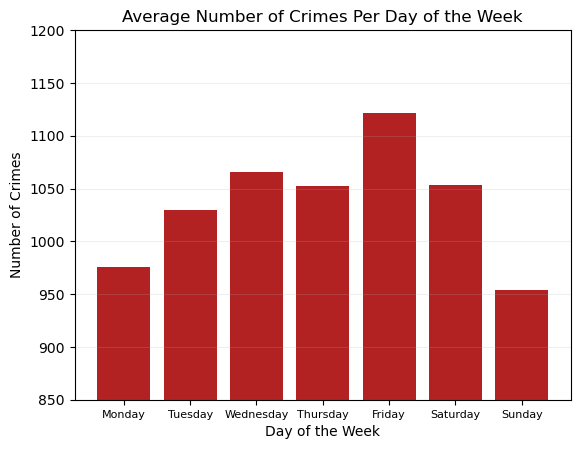

In [93]:
#create a bar chart to show the number of crimes based on the day of the week
plt.bar(day_of_week_df['day_of_week'], day_of_week_df['y'], color='firebrick')
plt.ylim(850,1200)
plt.xlabel('Day of the Week')
plt.xticks(fontsize=8)
plt.ylabel('Number of Crimes')
plt.title('Average Number of Crimes Per Day of the Week')
plt.grid(axis='y', alpha=.2)
plt.show()


In [94]:
top_crimes_daily_df = df
top_crimes_daily_df = top_crimes_daily_df[['cmplnt_fr_dt', 'ofns_desc']]
top_crimes_daily_df['cmplnt_fr_dt'] = top_crimes_daily_df['cmplnt_fr_dt'].str[:-13]
top_crimes_daily_df.head()

/var/folders/s5/83_c6qwd24vgpy6ybcz6q4ww0000gn/T/ipykernel_21307/1156195610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_crimes_daily_df['cmplnt_fr_dt'] = top_crimes_daily_df['cmplnt_fr_dt'].str[:-13]


,cmplnt_fr_dt,ofns_desc
0,2010-01-01,PETIT LARCENY
1,2010-01-01,PETIT LARCENY
2,2010-01-01,PETIT LARCENY
3,2010-01-01,PETIT LARCENY
4,2010-01-01,PETIT LARCENY


In [95]:
#rename columns as date and crime
top_crimes_daily_df = top_crimes_daily_df.rename(columns={'cmplnt_fr_dt': 'date', 'ofns_desc': 'crime'})
top_crimes_daily_df['date'] = pd.to_datetime(top_crimes_daily_df['date'])

#create a new column with the day of the week
top_crimes_daily_df['day_of_week'] = top_crimes_daily_df['date'].dt.day_name()

#count the frequency of each crime that occurs on each day of the week
top_crimes_daily_df = top_crimes_daily_df.groupby(['crime', 'day_of_week']).size().reset_index(name='count')

In [116]:
top_crimes_daily_df.sort_values(by='count', ascending=False).tail(10)

,crime,day_of_week,count
30,ANTICIPATORY OFFENSES,Saturday,8
182,INTOXICATED/IMPAIRED DRIVING,Friday,8
260,OFFENSES RELATED TO CHILDREN,Monday,7
221,NYS LAWS-UNCLASSIFIED VIOLATION,Thursday,6
187,INTOXICATED/IMPAIRED DRIVING,Tuesday,6
188,INTOXICATED/IMPAIRED DRIVING,Wednesday,5
31,ANTICIPATORY OFFENSES,Sunday,4
186,INTOXICATED/IMPAIRED DRIVING,Thursday,4
66,CANNABIS RELATED OFFENSES,Sunday,4
64,CANNABIS RELATED OFFENSES,Monday,4


In [97]:
#Find the top 5 crimes that occur on each day of the week
top5_crimes_daily_df = top_crimes_daily_df.sort_values(by='count', ascending=False).groupby('day_of_week').head(5).reset_index(drop=True)
top5_crimes_daily_df.head(35)

,crime,day_of_week,count
0,ASSAULT 3 & RELATED OFFENSES,Sunday,83516
1,ASSAULT 3 & RELATED OFFENSES,Saturday,80989
2,GRAND LARCENY,Friday,80154
3,CRIMINAL MISCHIEF & RELATED OF,Friday,77964
4,PETIT LARCENY,Friday,77689
5,CRIMINAL MISCHIEF & RELATED OF,Saturday,74855
6,PETIT LARCENY,Wednesday,74299
7,HARRASSMENT 2,Friday,74130
8,HARRASSMENT 2,Wednesday,73844
9,GRAND LARCENY,Monday,73643


In [113]:
top5_crimes_daily_df.tail()

,crime,day_of_week,count
30,HARRASSMENT 2,Saturday,66276
31,ASSAULT 3 & RELATED OFFENSES,Thursday,66013
32,ASSAULT 3 & RELATED OFFENSES,Tuesday,64367
33,PETIT LARCENY,Sunday,61496
34,GRAND LARCENY,Sunday,60325


In [108]:
#display just assaults
assaults = top5_crimes_daily_df[top5_crimes_daily_df['crime'] == 'ASSAULT 3 & RELATED OFFENSES']
assaults

,crime,day_of_week,count
0,ASSAULT 3 & RELATED OFFENSES,Sunday,83516
1,ASSAULT 3 & RELATED OFFENSES,Saturday,80989
19,ASSAULT 3 & RELATED OFFENSES,Friday,71492
27,ASSAULT 3 & RELATED OFFENSES,Monday,67279
29,ASSAULT 3 & RELATED OFFENSES,Wednesday,66344
31,ASSAULT 3 & RELATED OFFENSES,Thursday,66013
32,ASSAULT 3 & RELATED OFFENSES,Tuesday,64367


In [109]:
#display just grand larcenies
grand_larcenies = top5_crimes_daily_df[top5_crimes_daily_df['crime'] == 'GRAND LARCENY']
grand_larcenies

,crime,day_of_week,count
2,GRAND LARCENY,Friday,80154
9,GRAND LARCENY,Monday,73643
13,GRAND LARCENY,Wednesday,72606
15,GRAND LARCENY,Thursday,72331
17,GRAND LARCENY,Tuesday,71709
24,GRAND LARCENY,Saturday,69232
34,GRAND LARCENY,Sunday,60325


In [110]:
#display just harassments
harassments = top5_crimes_daily_df[top5_crimes_daily_df['crime'] == 'HARRASSMENT 2']
harassments

,crime,day_of_week,count
7,HARRASSMENT 2,Friday,74130
8,HARRASSMENT 2,Wednesday,73844
10,HARRASSMENT 2,Tuesday,72996
11,HARRASSMENT 2,Monday,72981
14,HARRASSMENT 2,Thursday,72578
28,HARRASSMENT 2,Sunday,67195
30,HARRASSMENT 2,Saturday,66276


In [111]:
#display just petit larcenies
petit_larcenies = top5_crimes_daily_df[top5_crimes_daily_df['crime'] == 'PETIT LARCENY']
petit_larcenies

,crime,day_of_week,count
4,PETIT LARCENY,Friday,77689
6,PETIT LARCENY,Wednesday,74299
12,PETIT LARCENY,Tuesday,72800
16,PETIT LARCENY,Thursday,72319
18,PETIT LARCENY,Monday,71630
22,PETIT LARCENY,Saturday,69767
33,PETIT LARCENY,Sunday,61496


In [98]:
time_of_day_df = df
time_of_day_df.head()

,cmplnt_fr_dt,cmplnt_fr_tm,ofns_desc,boro_nm,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex
0,2010-01-01T00:00:00.000,01:30:00,PETIT LARCENY,STATEN ISLAND,(null),UNKNOWN,U,45-64,WHITE,M
1,2010-01-01T00:00:00.000,12:00:00,PETIT LARCENY,STATEN ISLAND,(null),UNKNOWN,U,45-64,WHITE,F
2,2010-01-01T00:00:00.000,20:00:00,PETIT LARCENY,STATEN ISLAND,(null),(null),(null),(null),UNKNOWN,D
3,2010-01-01T00:00:00.000,10:00:00,PETIT LARCENY,STATEN ISLAND,18-24,WHITE,M,45-64,WHITE,F
4,2010-01-01T00:00:00.000,00:00:00,PETIT LARCENY,STATEN ISLAND,(null),UNKNOWN,U,25-44,WHITE,M


In [99]:
#remove all columns except 'cmplnt_fr_tm' and 'ofns_desc'
time_of_day_df = time_of_day_df[['cmplnt_fr_tm', 'ofns_desc']]
#sum all the crimes that happened at the same time
time_of_day_df = time_of_day_df.groupby('cmplnt_fr_tm').size().reset_index(name='y')
time_of_day_df.head(30)

,cmplnt_fr_tm,y
0,(null),4
1,00:00:00,40289
2,00:01:00,62144
3,00:02:00,1224
4,00:03:00,875
5,00:04:00,735
6,00:05:00,11682
7,00:06:00,684
8,00:07:00,655
9,00:08:00,846


In [101]:
time_of_day_df['cmplnt_fr_tm'] = time_of_day_df['cmplnt_fr_tm'].str[:2]

,cmplnt_fr_tm,y
0,(n,4
1,00,40289
2,00,62144
3,00,1224
4,00,875


In [102]:
#group the crimes by hour
time_of_day_df = time_of_day_df.groupby('cmplnt_fr_tm').sum().reset_index()

,cmplnt_fr_tm,y
0,(n,4
1,00,248479
2,01,173913
3,02,143482
4,03,121947
5,04,107127
6,05,75688
7,06,77284
8,07,103845
9,08,163168


In [103]:
#remove the first row
time_of_day_df = time_of_day_df.iloc[1:]

,cmplnt_fr_tm,y
1,00,248479
2,01,173913
3,02,143482
4,03,121947
5,04,107127
6,05,75688
7,06,77284
8,07,103845
9,08,163168
10,09,178886


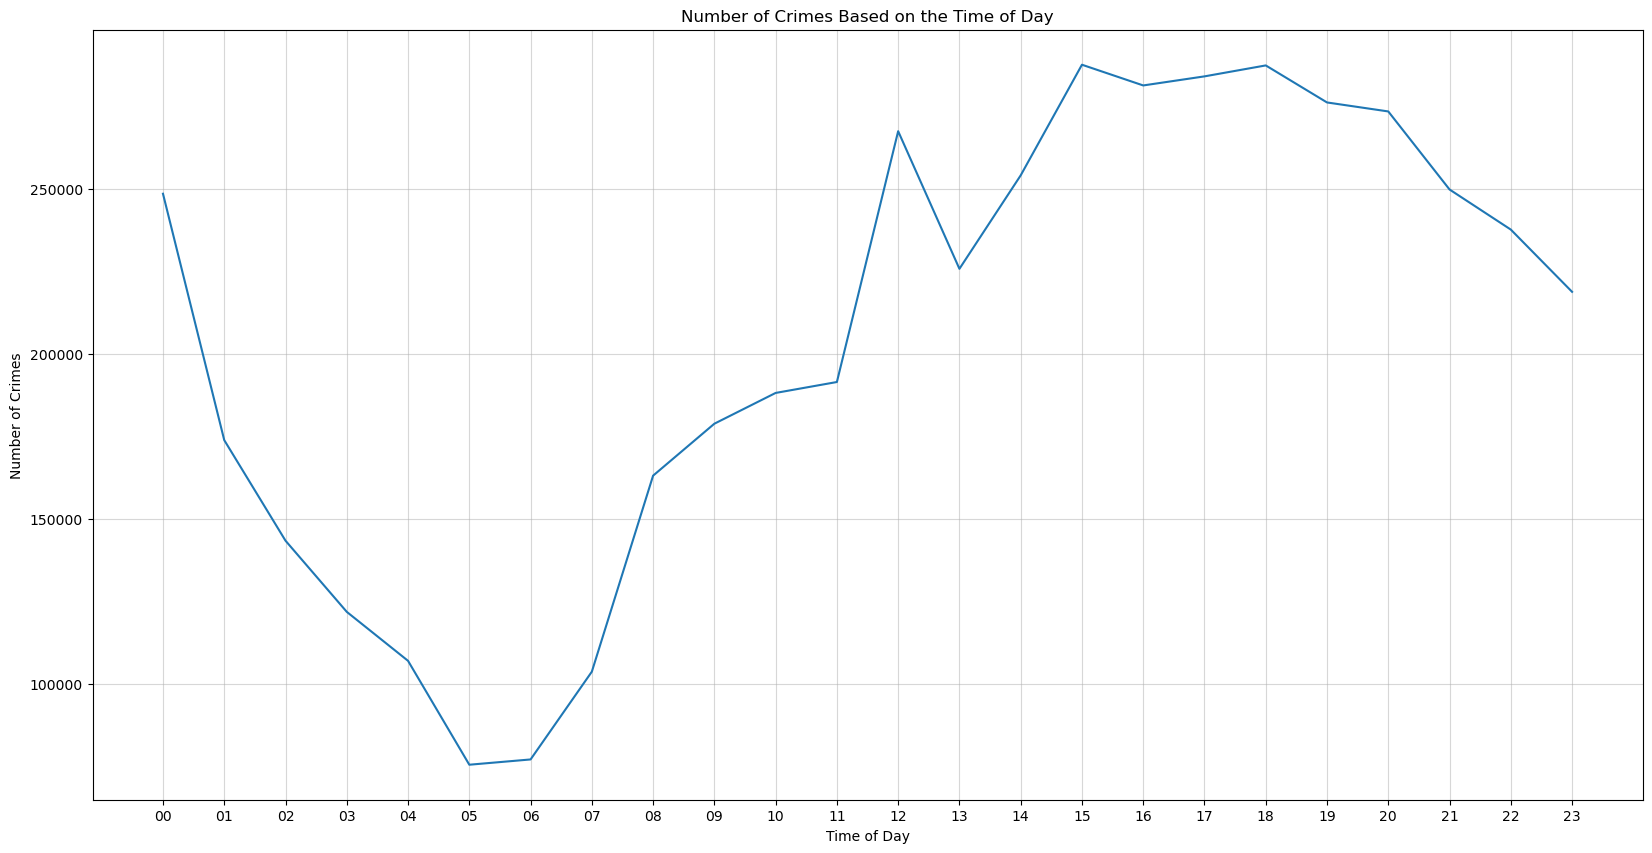

In [107]:
#make a line graph to show the number of crimes based on the time of day
plt.figure(figsize=(20, 10))
plt.plot(time_of_day_df['cmplnt_fr_tm'], time_of_day_df['y'])
plt.xlabel('Time of Day')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes Based on the Time of Day')
plt.grid(axis='y', alpha=.5)
plt.grid(axis='x', alpha=.5)
plt.show()